In [1]:
import torch, timm, requests, cv2
from glob import glob
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt

#### Dataset download : 10-class classification
url = https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset

In [2]:
path='/home/minhyeok/Data/Animals_10class/Validation Data'
# class_list = [case for case in os.listdir(path)]
# class_list

In [3]:
# np.random.randint(30)
CAT_list = glob(f'{path}/Cat/*')
Cow_list = glob(f'{path}/Cow/*')
Dog_list = glob(f'{path}/Dog/*')
Elephant_list = glob(f'{path}/Elephant/*')
Gorilla_list = glob(f'{path}/Gorilla/*')
Hippo_list = glob(f'{path}/Hippo/*')
Monkey_list = glob(f'{path}/Monkey/*')
Panda_list = glob(f'{path}/Panda/*')
Tiger_list = glob(f'{path}/Tiger/*')
Zebra_list = glob(f'{path}/Zebra/*')

In [4]:
def patch_img(img, patch):
    '''PIL image object를 넣어주세요'''
    width, height = img.size
    patch = cv2.resize(patch, (width//4, height//4), cv2.INTER_LINEAR)
    alpha = np.random.randint(height-patch.shape[0])
    beta =  np.random.randint(width-patch.shape[1])
    img = np.array(img)
    roi = img[alpha:alpha+patch.shape[0], beta:beta+patch.shape[1],]
    dst = np.where(patch>1, patch, roi)
    img[alpha:alpha+patch.shape[0], beta:beta+patch.shape[1]] = dst
    img = Image.fromarray(img)
    
    return img

In [5]:
def choice(ls):
    img_list = ls[np.random.randint(len(ls))]
    return Image.open(img_list)

In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

### Model definition

In [11]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

ViT = timm.create_model('vit_base_patch16_224', pretrained=True)

config = resolve_data_config({}, model=ViT)
transform = create_transform(**config)

resnet50 = models.resnet50(pretrained=True)

densenet121 = models.densenet121(pretrained=True)

#### Image check

In [1]:
# list input
img=choice(Dog_list)

patch=cv2.imread('/home/minhyeok/Data/adversarial patch (toaster).png', cv2.IMREAD_COLOR)
img=patch_img(img, patch)
plt.subplot(121)
plt.imshow(img)

transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
input.size()
plt.subplot(122)
plt.imshow(np.transpose(torch.squeeze(input, 0).numpy(),(1,2,0)))
plt.show

NameError: name 'choice' is not defined

#### label preparation

In [10]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

--2022-12-04 15:49:22--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.130.240, 52.217.193.64, 52.216.248.150, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.130.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/minhyeok/.torch/models/imagenet_class_index.json.20’

imagenet_class_inde 100%[===================>]  34.53K   193KB/s    in 0.2s    

2022-12-04 15:49:23 (193 KB/s) - ‘/home/minhyeok/.torch/models/imagenet_class_index.json.20’ saved [35363/35363]



### XAI method
 - IG
 - Gradient Shap
 - Occulusion

In [23]:
# model 
model = densenet121.eval()

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                [(0, '#ffffff'),
                                                (0.25, '#000000'),
                                                (1, '#000000')], N=256)

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)



Predicted: paintbrush ( 0.02846432290971279 )


: 

: 

#### visualization

In [16]:
save_path='/home/minhyeok/result_img'
model_list=['ViT','Resnet50','Densenet121']
model_name=model_list[1]

IG,_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                            np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                            "heat_map",
                            "all",
                            show_colorbar=True,
                            fig_size=(6,6),
                            cmap=default_cmap,
                            title= "IG",
                            # sign='positive',
                            outlier_perc=1,
                            use_pyplot=False)

IG.savefig(f'{save_path}/{model_name}_{predicted_label}_IG.png')

Tn,_ = viz.visualize_image_attr(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                    method="heat_map",
                                    sign='positive',
                                    cmap=default_cmap,
                                    fig_size=(4,4),
                                    title="Tunnel",
                                    show_colorbar=True,
                                    use_pyplot=False)

Tn.savefig(f'{save_path}/{model_name}_{predicted_label}_Tunnel.png')

Sh,_ = viz.visualize_image_attr(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method="heat_map",
                                      sign='positive',
                                      cmap=default_cmap,
                                    title="Shap",                                      
                                      fig_size=(4,4),
                                      show_colorbar=True,use_pyplot=False)

Sh.savefig(f'{save_path}/{model_name}_{predicted_label}_Shap.png')

Occ,_ = viz.visualize_image_attr(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method="heat_map",
                                      sign='positive',
                                    title= "Occulusion",
                                      show_colorbar=True,
                                      fig_size=(4,4),
                                      outlier_perc=2,use_pyplot=False
                                     )

Occ.savefig(f'{save_path}/{model_name}_{predicted_label}_Occ.png')

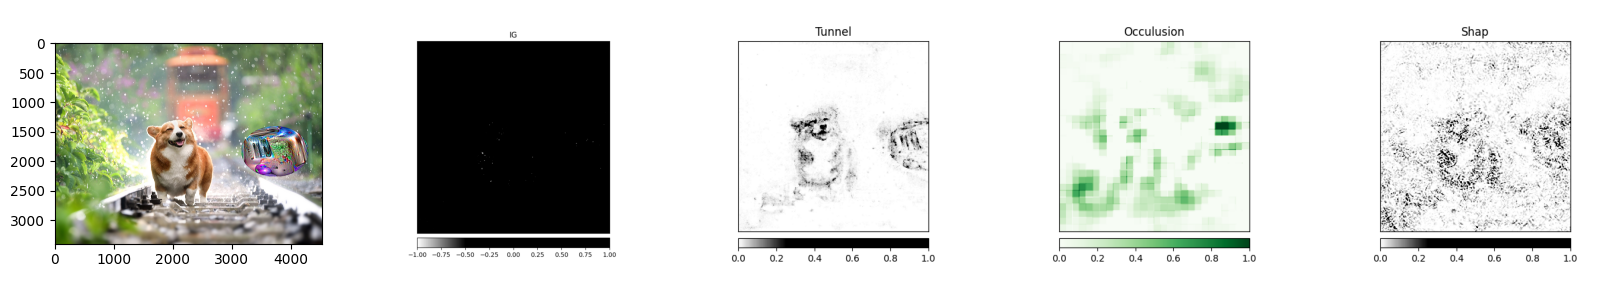

In [22]:
img_list= glob(f'{save_path}/{model_name}_{predicted_label}*.png')
fig=plt.figure(figsize=(20,8))
fig.tight_layout()
plt.subplot(151)
plt.imshow(img)
plt.subplot(152)
plt.axis('off')
plt.imshow(Image.open(img_list[0]))
plt.subplot(153)
plt.axis('off')
plt.imshow(Image.open(img_list[1]))
plt.subplot(154)
plt.axis('off')
plt.imshow(Image.open(img_list[2]))
plt.subplot(155)
plt.axis('off')
plt.imshow(Image.open(img_list[3]))
plt.show()